# COMP0169: Machine Learning for Visual Computing
Week 6

This lab notebook was developed by David Walton & Pradyumnna Reddy for the COMP0169 course at UCL (2020).



In [1]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2

**Note for Colab users**: This coursework uses 3 image files (portico.jpg, apple.webp and orange.webp). You can upload these to your running colab instance by clicking on the files tab on the left (image of a folder) and then clicking the upload button.

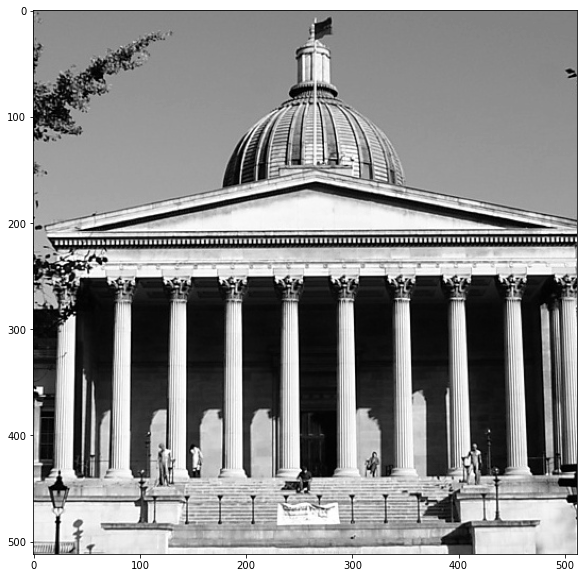

In [2]:
def show_grayscale_im(image):
  plt.figure(figsize=(10,10))
  plt.imshow(image, cmap="gray", vmin=0, vmax=1)

portico_image = cv2.imread("portico.jpg").astype(float) / 255.0
portico_image = portico_image[...,0]
show_grayscale_im(portico_image)

# 2D Image Filtering


## Filtering with a mean kernel
Here we filter using a simple mean kernel, often called a box kernel. This is equivalent to taking the mean in a window around each pixel in the image. The box kernel smooths the image but creates some "boxy" artefacts in the output (look closely at the flag on top of the portico). 

Although they have some artefacts, box filters because they can be implemented using summed area tables, which makes them extremely fast (https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.90.8836&rep=rep1&type=pdf)

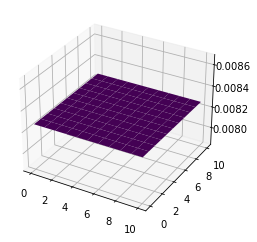

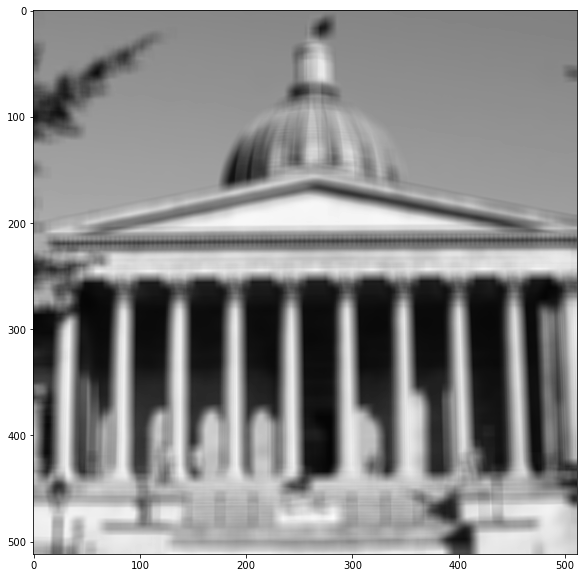

In [3]:
def plot_kernel_3d(kernel):
  plt.figure()
  ax = plt.axes(projection='3d')
  x = np.ones(kernel.shape)
  y = np.ones(kernel.shape)
  for i in range(kernel.shape[0]):
    x[i,:] = i
  for i in range(kernel.shape[1]):
    y[:,i] = i
  ax.plot_surface(x, y, kernel,cmap='viridis', edgecolor='none')

box_kernel = np.ones([11,11])
box_kernel /= box_kernel.sum()
plot_kernel_3d(box_kernel)
box_filtered_portico = cv2.filter2D(portico_image, -1, box_kernel)
show_grayscale_im(box_filtered_portico)

## Filtering with a Gaussian Kernel
Here we filter with a Gaussian kernel. The coefficients of this are taken from a 2D Gaussian function. Note that whilst it also smooths the image (removes high frequencies) it avoids the "boxy" artefacts of the kernel above.

I've used OpenCV's built in functions here, but you'll need to generate a Gaussian kernel and implement the filtering from scratch in your coursework.

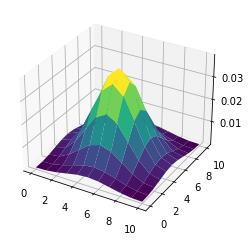

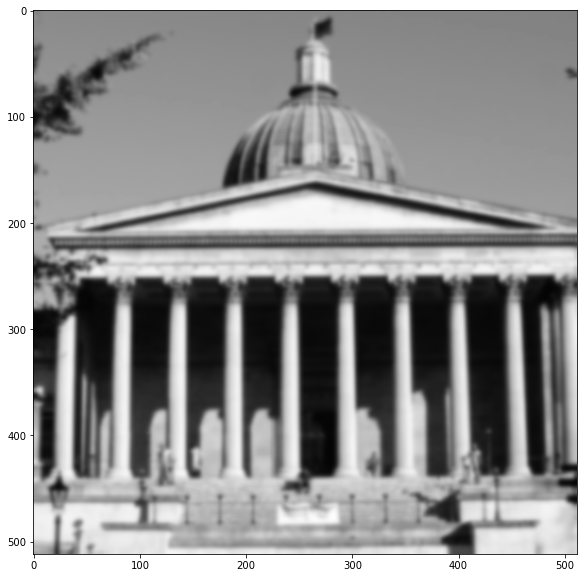

In [4]:
#Making kernel with OpenCV (code here is not important)
gaussian_kernel = np.zeros([11,11])
gaussian_kernel[5,5] = 1.0
gaussian_kernel = cv2.GaussianBlur(gaussian_kernel, (11,11), 2)
gaussian_kernel /= gaussian_kernel.sum()

#Plot kernel, filter and display output
plot_kernel_3d(gaussian_kernel)
gaussian_portico = cv2.filter2D(portico_image, -1, gaussian_kernel)
show_grayscale_im(gaussian_portico)

## Exercise: Try Other Kernels

Try to filter the portico image using this filter kernel:

[ 0, -1,  0]

[-1,  5, -1]

[ 0, -1,  0]

Display the results. What effect does it have on the image?

Try this kernel

[-1, -1, -1]

[-1,  8, -1]

[-1, -1, -1]

If you have ideas for other kernels, try them out and display the results.

# Enhancing Higher Frequencies
What if we want to instead get only the high frequencies from the image? One straightforward idea is just to subtract the low-frequency image from the original one.

## Exercise: Enhancing higher frequencies

Try subtracting the gaussian filtered portico image from the original one, to get a result containing only high frequencies.

high_freq = portico_image - gaussian_filter(portico_image)

Add a multiple of this high_freq representation on to the original image:

output = portico_image + alpha*high_freq

What does this do? What effect does changing alpha have?

# Fourier Transform of an Image
Here we'll take the Fourier transform of the portico image.

The image data consists of discrete samples, so we will take the discrete fourier transform (DFT) of the image.

This is computed using an algorithm called the fast fourier transform (FFT).

Remember, the DFT is the approach, and the FFT is the algorithm.

The fourier transform is complex-valued, so we can't plot it directly. People normally take the energy of the fourier transform and plot this (this is the square of the absolute value of the fourier transform).

Also note that we use fftshift - this just rearranges the image so the low frequencies are at the centre and the high frequencies are at the edges.

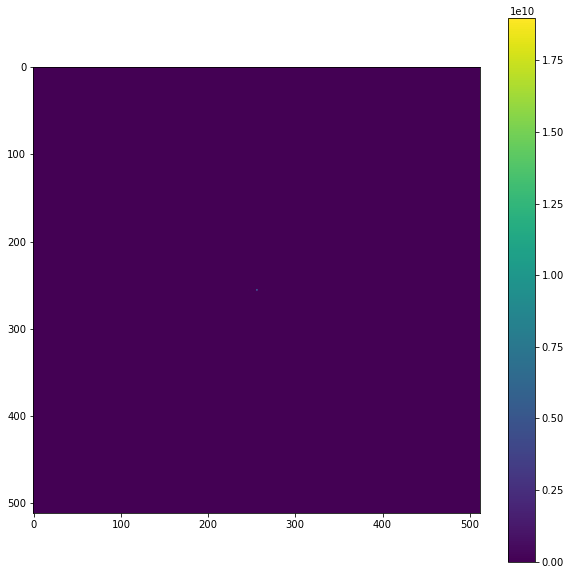

In [5]:
fourier_portico = np.fft.fft2(portico_image)
fourier_portico = np.fft.fftshift(fourier_portico)
plt.figure(figsize=(10,10))
plt.imshow(np.abs(fourier_portico)**2)
plt.colorbar()

Oops! We can't see the result at all. The problem is the results go over a huge range and the central pixel (lowest frequency) has a huge value. Because of this people normally plot the logarithm of the energy. We also add one to ensure that if the energy is zero, the logarithm is still valid.

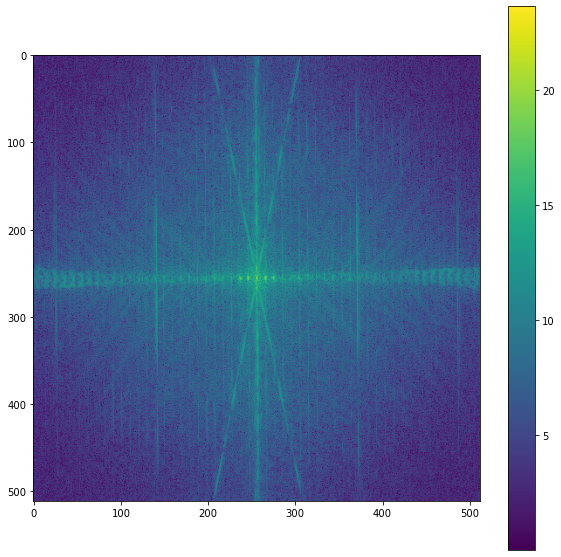

In [6]:
fourier_portico = np.fft.fft2(portico_image)
fourier_portico = np.fft.fftshift(fourier_portico)
plt.figure(figsize=(10,10))
plt.imshow(np.log(np.abs(fourier_portico)**2 + 1))
plt.colorbar()

You might notice the result is symmetric. This is always the case when you take the fourier transform of a real signal. You can save some work by just computing half of the values (in numpy, this is the rfft function):

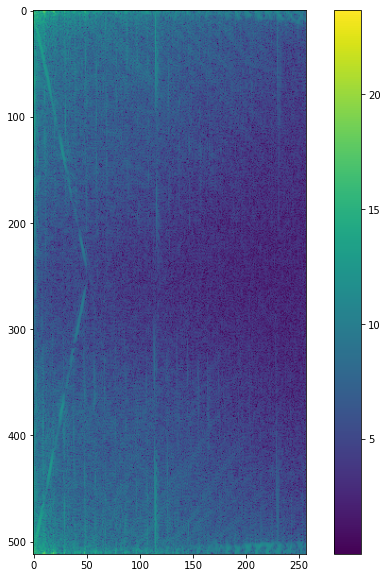

In [7]:
fourier_portico = np.fft.rfft2(portico_image)
plt.figure(figsize=(10,10))
plt.imshow(np.log(np.abs(fourier_portico)**2 + 1))
plt.colorbar()

## Properties of the Fourier Transform
The Fourier transform is invertible, and we can recover the original image using the inverse Fourier transform:

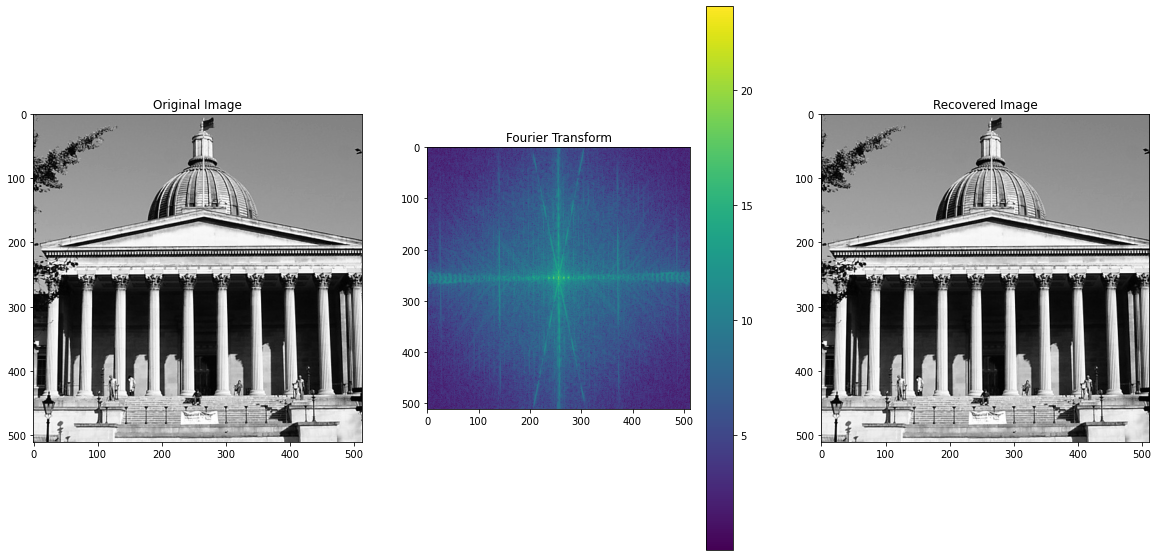

In [8]:
fourier_portico = np.fft.fft2(portico_image)
fourier_portico = np.fft.fftshift(fourier_portico)
#We need np.real here because ifft2 returns complex values.
#The imaginary part of the recovered image is zero.
#Note that since we used fftshift earlier, we need to reverse it using ifftshift
recovered_image = np.real(np.fft.ifft2(np.fft.ifftshift(fourier_portico)))
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.title("Original Image")
plt.imshow(portico_image, cmap="gray", vmin=0, vmax=1)
plt.subplot(1,3,2)
plt.title("Fourier Transform")
plt.imshow(np.log(np.abs(fourier_portico)**2 + 1))
plt.colorbar()
plt.subplot(1,3,3)
plt.title("Recovered Image")
plt.imshow(recovered_image, cmap="gray", vmin=0, vmax=1)

One very important property of the Fourier transform is the convolution theorem. This says that convolution in the spatial domain is equivalent to (elementwise) multiplication in the fourier domain.

That is, convolve(a, b) = F^-1(F(a) * F(b))

This is very useful, as the multiplication is normally much faster than convolution, particularly if the kernel size is large.

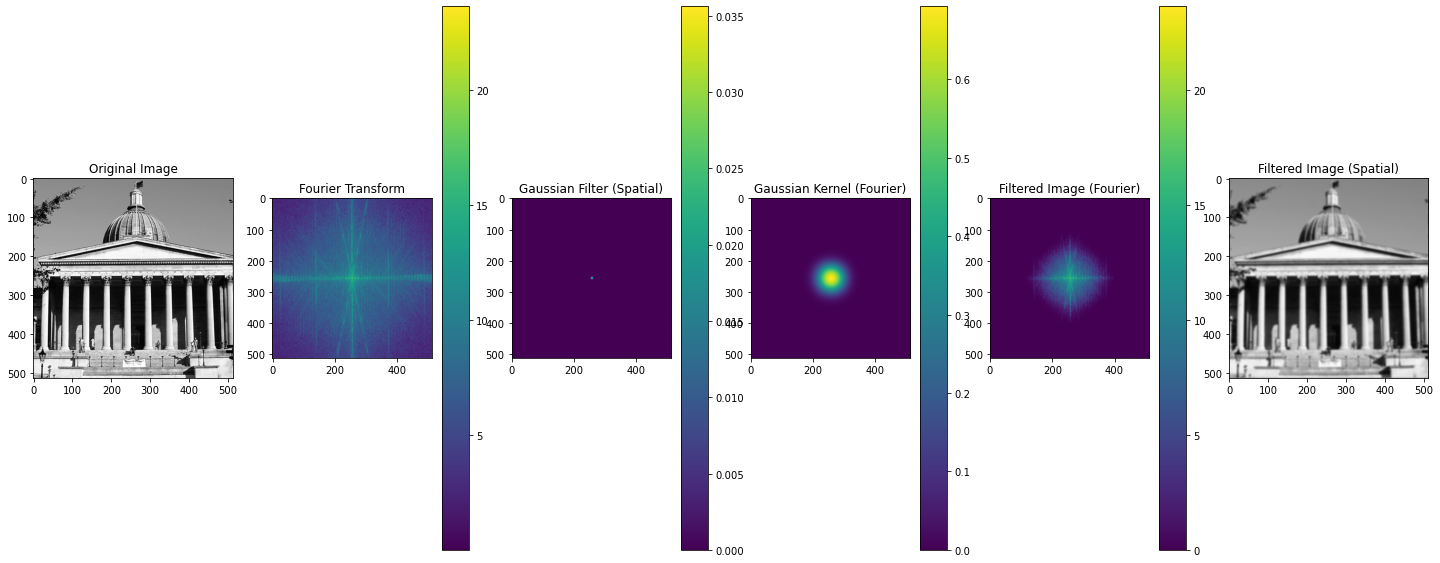

In [9]:
#Making kernel with OpenCV (code here is not important)
gaussian_kernel = np.zeros([512,512])
gaussian_kernel[255:257,255:257] = 1.0
gaussian_kernel = cv2.GaussianBlur(gaussian_kernel, (11,11), 2)
gaussian_kernel /= gaussian_kernel.sum()

gaussian_kernel_fourier = np.fft.fftshift(np.fft.fft2(gaussian_kernel))

fourier_portico = np.fft.fftshift(np.fft.fft2(portico_image))

filtered_fourier = fourier_portico * gaussian_kernel_fourier

filtered_spatial = np.fft.fftshift(np.real(np.fft.ifft2(np.fft.ifftshift(filtered_fourier))))

plt.figure(figsize=(25,10))
plt.subplot(1,6,1)
plt.title("Original Image")
plt.imshow(portico_image, cmap="gray", vmin=0, vmax=1)
plt.subplot(1,6,2)
plt.title("Fourier Transform")
plt.imshow(np.log(np.abs(fourier_portico)**2 + 1))
plt.colorbar()
plt.subplot(1,6,3)
plt.title("Gaussian Filter (Spatial)")
plt.imshow(gaussian_kernel)
plt.colorbar()
plt.subplot(1,6,4)
plt.title("Gaussian Kernel (Fourier)")
plt.imshow(np.log(np.abs(gaussian_kernel_fourier)**2 + 1))
plt.colorbar()
plt.subplot(1,6,5)
plt.title("Filtered Image (Fourier)")
plt.imshow(np.log(np.abs(filtered_fourier)**2 + 1))
plt.colorbar()
plt.subplot(1,6,6)
plt.title("Filtered Image (Spatial)")
plt.imshow(filtered_spatial, cmap="gray", vmin=0, vmax=1)

# Ideal Filters
If we want to implement a low-pass filter, we could choose to remove the high frequencies directly in the frequency domain. Here, we'll try doing this by multiplying the fourier transform with a mask, which is zero for the higher frequencies (i.e. for the outer pixels in the frequency domain).

## Exercise: Ideal Fitlers
Implement an ideal low-pass image filter. Transform the portico image to the fourier domain. 

Now, set all the values more than a set distance from the centre of the fourier transformed image (e.g. 50 pixels) to zero. Then reconstruct and check out the result.

Did it smooth the image, as expected? What do you notice about the results?

# Image Pyramids
In the lecture Tobias mentioned that image pyramids are often used to analyse images at multiple scales. Here we will take a look at two pyramids and an application for them.



## Gaussian Pyramid
The first is the Gaussian Pyramid. This is made by taking an image, and repeatedly filtering it with a Gaussian filter, then downsampling it.

The filtering is important as it avoids aliasing, which occurs when a signal is sampled below its Nyquist frequency.

Here, we'll use pyrDown() from the openCV library, which does these two steps for us.

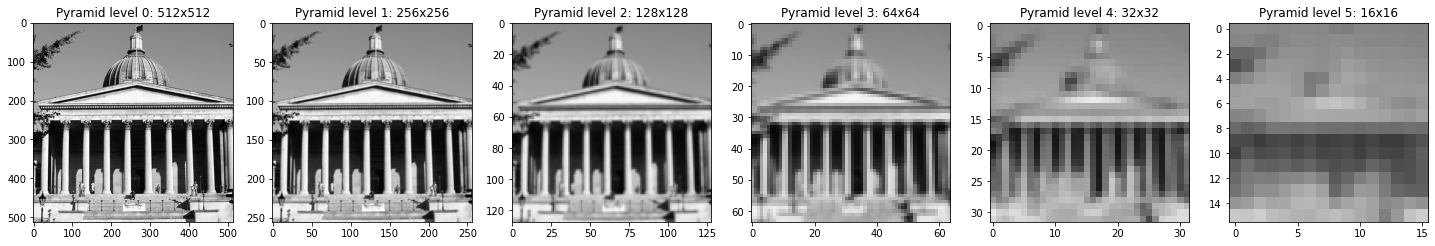

In [10]:
num_levels = 5

gaussian_pyramid = [portico_image]
for i in range(num_levels):
  gaussian_pyramid.append(cv2.pyrDown(gaussian_pyramid[-1]))

plt.figure(figsize=(25,10))
for i in range(len(gaussian_pyramid)):
  plt.subplot(1, len(gaussian_pyramid), i+1)
  plt.title("Pyramid level %d: %dx%d" % (i, gaussian_pyramid[i].shape[0], gaussian_pyramid[i].shape[1]))
  plt.imshow(gaussian_pyramid[i], cmap="gray", vmin=0, vmax=1)

## Laplacian Pyramid

The Laplacian pyramid is strongly related to the Gaussian pyramid. Each level is the difference between two levels of the Gaussian pyramid. The last level (the smallest one) is identical to the Gaussian pyramid.

You'll probably notice that we can't subtract the levels straight away because they are of different sizes. To get each pair of levels to the same size, we upsample the smaller image and then blur it. 

For this we use pyrUp() from the opencv library, which upsamples and filters the image. 

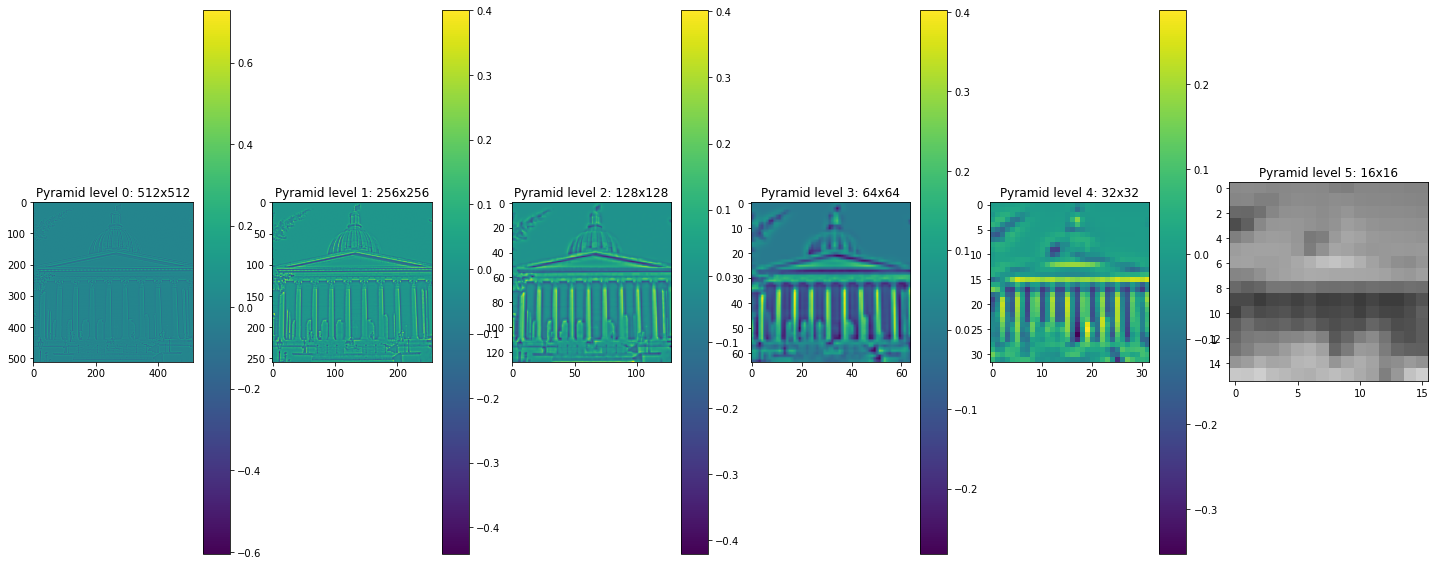

In [11]:
laplacian_pyramid = [gaussian_pyramid[-1]]
for i in reversed(range(len(gaussian_pyramid)-1)):
  laplacian_pyramid.insert(0, gaussian_pyramid[i] - cv2.pyrUp(gaussian_pyramid[i+1]))

plt.figure(figsize=(25,10))
for i in range(len(laplacian_pyramid)):
  plt.subplot(1, len(laplacian_pyramid), i+1)
  plt.title("Pyramid level %d: %dx%d" % (i, laplacian_pyramid[i].shape[0], laplacian_pyramid[i].shape[1]))
  if i < len(laplacian_pyramid)-1:
    plt.imshow(laplacian_pyramid[i])
    plt.colorbar()
  else:
    plt.imshow(laplacian_pyramid[i], cmap="gray", vmin=0, vmax=1)

The Laplacian pyramid isn't always positive-valued, except for the lowest-resolution level. This is because each level is a difference between two images.

This pyramid is useful because each level captures the high-frequency information that can't be expressed in the level below it.

We can reconstruct an image from its laplacian pyramid by adding the layers.

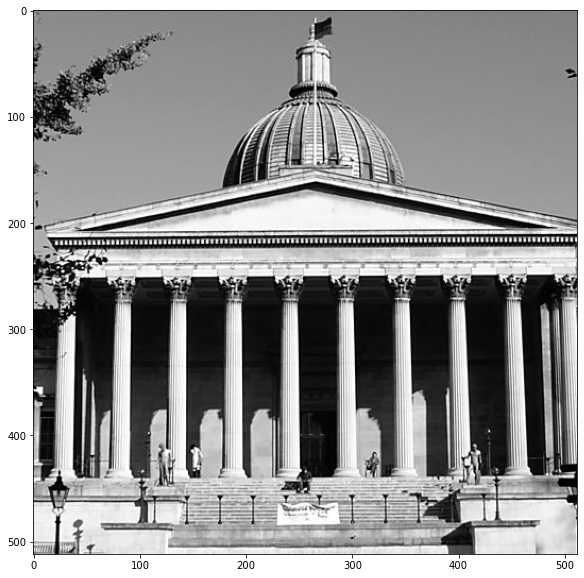

In [12]:
reconstructed_image = laplacian_pyramid[-1]
for layer in reversed(laplacian_pyramid[:-1]):
  reconstructed_image = cv2.pyrUp(reconstructed_image) + layer

plt.figure(figsize=(10,10))
plt.imshow(reconstructed_image, cmap="gray", vmin=0, vmax=1)

Laplacian and Gaussian pyramids have a lot of useful applications, but one fun application for Laplacian pyramids is image blending. Two images can be blended smoothly by just combining each of their Laplacian pyramid levels, and then reconstructing from the resulting pyramid.

The original paper by Burt and Adelson introducing this blending process is here: http://persci.mit.edu/pub_pdfs/spline83.pdf

Lets refactor the pyramid code into functions first:

In [13]:
def make_gaussian_pyramid(image, num_levels):
  gaussian_pyramid = [image]
  for i in range(num_levels-1):
    gaussian_pyramid.append(cv2.pyrDown(gaussian_pyramid[-1]))
  return gaussian_pyramid

def make_laplacian_pyramid(gaussian_pyramid):
  laplacian_pyramid = [gaussian_pyramid[-1]]
  for i in reversed(range(len(gaussian_pyramid)-1)):
    laplacian_pyramid.insert(0, gaussian_pyramid[i] - cv2.pyrUp(gaussian_pyramid[i+1]))
  return laplacian_pyramid

def reconstruct_from_laplacian_pyramid(laplacian_pyramid):
  reconstructed_image = laplacian_pyramid[-1]
  for layer in reversed(laplacian_pyramid[:-1]):
    reconstructed_image = cv2.pyrUp(reconstructed_image) + layer
  return reconstructed_image

def display_laplacian_pyramid(laplacian_pyramid):
  plt.figure(figsize=(25,10))
  for i in range(len(laplacian_pyramid)):
    plt.subplot(1, len(laplacian_pyramid), i+1)
    plt.title("Pyramid level %d: %dx%d" % (i, laplacian_pyramid[i].shape[0], laplacian_pyramid[i].shape[1]))
    if i < len(laplacian_pyramid)-1:
      plt.imshow(laplacian_pyramid[i])
      plt.colorbar()
    else:
      plt.imshow(laplacian_pyramid[i], cmap="gray", vmin=0, vmax=1)

Now lets get the images we want to combine. I've used the classic example of an apple and an orange here. If we just take the left and right of the apple & orange respectively, the hard edge between the two is very visible.

We want to try to smoothly blend them, to give a result like figure 7 in the paper: http://persci.mit.edu/pub_pdfs/spline83.pdf


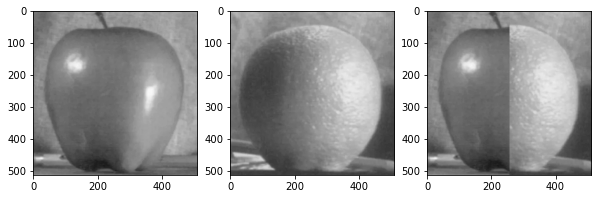

In [14]:
apple_image = cv2.imread("apple.webp")[...,0].astype(float) / 255.0
orange_image = cv2.imread("orange.webp")[...,0].astype(float) / 255.0
apple_left = apple_image[:, :apple_image.shape[1]//2]
orange_right = orange_image[:, orange_image.shape[1]//2:]
combined = np.concatenate([apple_left, orange_right], 1)

plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(apple_image, cmap="gray", vmin=0, vmax=1)
plt.subplot(1,3,2)
plt.imshow(orange_image, cmap="gray", vmin=0, vmax=1)
plt.subplot(1,3,3)
plt.imshow(combined, cmap="gray", vmin=0, vmax=1)


## Exercise: Laplacian Pyramid Blending

Blend these two images together smoothly using the Laplacian pyramid blending technique.

Take the Laplacian pyramid of each. Make a new Laplacian pyramid, where each level consists of (for example) the left side of the apple pyramid level and the right side of the orange pyramid level. Reconstruct an image from this pyramid.

What result do you get? Try combining different regions of the images, or using other input images. Check out figure 8 in the paper for an example of what is possible: http://persci.mit.edu/pub_pdfs/spline83.pdf